# Natural Language Processing (NLP): Bag-of-words model

## Import statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string

plt.style.use('seaborn-pastel')

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read in csv data
Steam is a video game digital distribution service with a vast community of gamers globally. A lot of gamers write reviews on the game page and have the option of choosing whether they would recommend this game to others or not.  
**review_id** --> Unique ID for each review  
**title** --> Title of the game  
**year** --> Year in which the review was posted  
**user_review** --> Full Text of the review posted by a user  
**user_suggestion** --> (Target) Game marked Recommended(1) and Not Recommended(0) by the user

In [3]:
steam = pd.read_csv("https://raw.githubusercontent.com/BaroqueObama/hhs-ws-bag-of-words/main/steam.csv",encoding='ISO-8859-1') # encoding='ISO-8859-1' allows us to read unicode characters without issue
# We're only using 30% of the available data because Colab crashes.
steam = steam.sample(frac=0.3)
display(steam)

,review_id,title,year,user_review,user_suggestion
3289,3753,Ring of Elysium,2018.0,Early Access ReviewThis Game is amazing 10/10 ...,1
11302,16799,Eternal Card Game,2018.0,I've read a lot of reviews comparing this game...,0
9148,12158,PlanetSide 2,2017.0,The Best online non ww2 FPS with massive batt...,1
15614,23049,AdventureQuest 3D,2017.0,Early Access ReviewI'ts good. Considering its ...,1
6035,8410,DCS World Steam Edition,2017.0,"Clearly a great sim, but there are major perfo...",1
...,...,...,...,...,...
2971,3435,War Thunder,2018.0,"Absolutely not worth your time, I promise you....",0
13800,19744,Creativerse,2016.0,Early Access ReviewVery nice cartoonish feel t...,1
16639,24608,Bloons TD Battles,2017.0,If you've ever played any of the blo...,1
12712,18209,RaceRoom Racing Experience,2016.0,"This game created a new concept, Free to play-...",0


### Drop uneeded columns (review_id, title, year) and NaN values if any

In [4]:
steam.drop(columns=steam.columns[0:3],inplace=True)
steam.dropna(axis=0,inplace=True)
display(steam)

,user_review,user_suggestion
3289,Early Access ReviewThis Game is amazing 10/10 ...,1
11302,I've read a lot of reviews comparing this game...,0
9148,The Best online non ww2 FPS with massive batt...,1
15614,Early Access ReviewI'ts good. Considering its ...,1
6035,"Clearly a great sim, but there are major perfo...",1
...,...,...
2971,"Absolutely not worth your time, I promise you....",0
13800,Early Access ReviewVery nice cartoonish feel t...,1
16639,If you've ever played any of the blo...,1
12712,"This game created a new concept, Free to play-...",0


### Plot the distribution between Recommended and Not Recommended game reviews

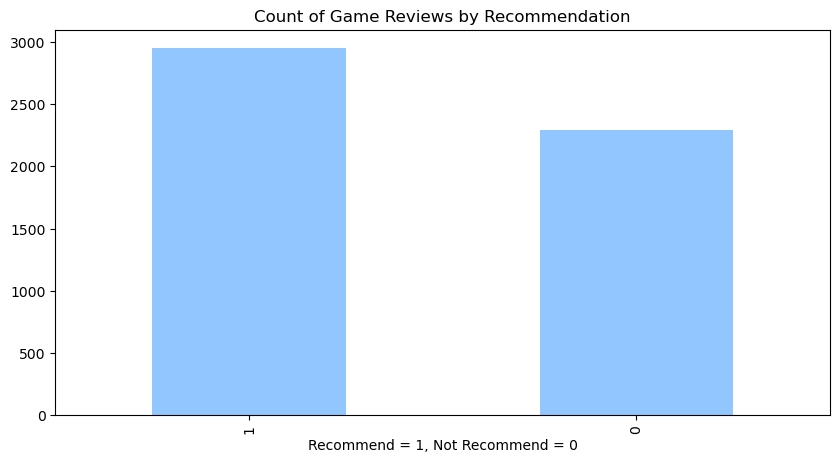

In [5]:
ax = steam[steam.columns[1]].value_counts().plot(kind='bar', title='Count of Game Reviews by Recommendation', figsize=(10, 5))
ax.set_xlabel('Recommend = 1, Not Recommend = 0')
plt.show()

## Tokenize a string by splitting it into a list of words (split at each space)

In [6]:
test_string = "I ain't got much sleeping last-night. Don't you think 3 hours' sleep is enough?"
print(test_string)

I ain't got much sleeping last-night. Don't you think 3 hours' sleep is enough?


In [7]:
tokens = test_string.split() # Hint, use .split()
#["I", "ain't", "got", "much", "sleeping", "last-night.", ...]
print(tokens)

['I', "ain't", 'got', 'much', 'sleeping', 'last-night.', "Don't", 'you', 'think', '3', "hours'", 'sleep', 'is', 'enough?']


### Solution Here
<details>
  <summary>Click to reveal answer. </summary>

```python
tokens = test_string.split()
print(tokens)
```
(You still have to copy paste this code and run it)
</details>

## Now tokenize all the reviews in the DataFrame

### We can tokenize all the items by applying a lambda (anonymous) function to each element.

In [8]:
# Lambda functions are just un-named functions

# Regular function
def add_one(input_number):
    return input_number + 1

# Lambda function named "add_one"
add_one = lambda input_number: input_number + 1

# Both these do the same thing. 

In [9]:
steam["basic_tokenize"] = steam["user_review"].apply(lambda review: review.split()) #Apply your tokenization to the review variable here)
display(steam)

,user_review,user_suggestion,basic_tokenize
3289,Early Access ReviewThis Game is amazing 10/10 ...,1,"[Early, Access, ReviewThis, Game, is, amazing,..."
11302,I've read a lot of reviews comparing this game...,0,"[I've, read, a, lot, of, reviews, comparing, t..."
9148,The Best online non ww2 FPS with massive batt...,1,"[The, Best, online, non, ww2, FPS, with, massi..."
15614,Early Access ReviewI'ts good. Considering its ...,1,"[Early, Access, ReviewI'ts, good., Considering..."
6035,"Clearly a great sim, but there are major perfo...",1,"[Clearly, a, great, sim,, but, there, are, maj..."
...,...,...,...
2971,"Absolutely not worth your time, I promise you....",0,"[Absolutely, not, worth, your, time,, I, promi..."
13800,Early Access ReviewVery nice cartoonish feel t...,1,"[Early, Access, ReviewVery, nice, cartoonish, ..."
16639,If you've ever played any of the blo...,1,"[If, you've, ever, played, any, of, the, bloon..."
12712,"This game created a new concept, Free to play-...",0,"[This, game, created, a, new, concept,, Free, ..."


### Solution Here
<details>
  <summary>Click to reveal answer. </summary>

```python
steam["basic_tokenize"] = steam["user_review"].apply(lambda review: review.split(" "))
display(steam)
```
(You still have to copy paste this code and run it)
</details>

## Let's plot what kind of tokens were made!

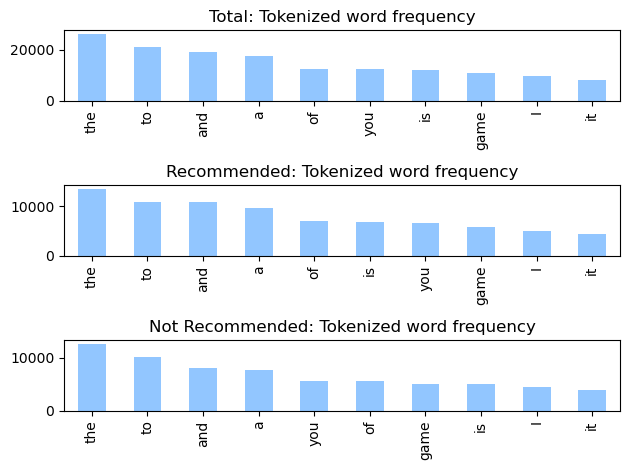

In [10]:
plt.subplot(3, 1, 1)
steam["basic_tokenize"].explode().value_counts().head(10).plot(kind='bar', title='Total: Tokenized word frequency')
plt.subplot(3, 1, 2)
steam[steam["user_suggestion"]==1]["basic_tokenize"].explode().value_counts().head(10).plot(kind='bar', title='Recommended: Tokenized word frequency')
plt.subplot(3, 1, 3)
ax = steam[steam["user_suggestion"]==0]["basic_tokenize"].explode().value_counts().head(10).plot(kind='bar', title='Not Recommended: Tokenized word frequency')
plt.tight_layout()
plt.show()

## Let's now turn these tokens into something a model can comprehend (numbers)!

### X is the input (tokens), y is what we try to predict (1 = Recommend, 0 = Does not recommend)

In [11]:
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(steam["basic_tokenize"].values)
y = steam["user_suggestion"]
print(X.shape)

(5248, 66376)


### Let's split our data into train and test sets and train our Naive Bayes Model!

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

## Evaluate the Model

Accuracy: 0.8071646341463414


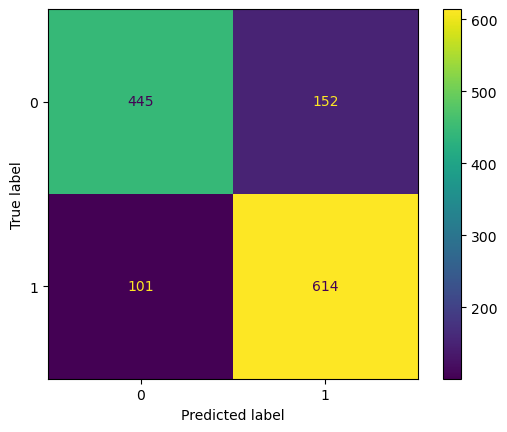

In [13]:
y_pred = model.predict(X_test)
#display(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## Test the model for yourself!

In [14]:
def try_basic_model(game_review):
    tokens = game_review.split(" ")
    mat = [[int(mlb.classes_[i] in tokens) for i in range(len(mlb.classes_))]]
    if model.predict(mat) == 1:
        return f"Model predicts Recommend. Tokens: {tokens}"
    else:
        return f"Model predicts Does Not Recommend. Tokens: {tokens}"


### Type in any hypothetical game review

In [15]:
try_basic_model("This game is bad")

"Model predicts Recommend. Tokens: ['This', 'game', 'is', 'bad']"

# Improving the model: Tokenize better

In [16]:
test_string = "I ain't got much sleeping last-night. Don't you think 3 hours' sleep is enough?"
print(test_string)

I ain't got much sleeping last-night. Don't you think 3 hours' sleep is enough?


### Split the text into more detail using nltk.word_tokenize

In [17]:
tokens = nltk.word_tokenize(test_string)
print(tokens)

['I', 'ai', "n't", 'got', 'much', 'sleeping', 'last-night', '.', 'Do', "n't", 'you', 'think', '3', 'hours', "'", 'sleep', 'is', 'enough', '?']


### Stop words: Frequent words that don't carry much meaning (Using stopwords)
Try to remove these words

In [18]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'d', 'if', 'will', 'herself', 'as', 'by', 'some', 'did', 'themselves', 'over', 'can', 'that', 's', 'ma', 'these', "aren't", 'down', 'then', 'again', 'wasn', 'ourselves', 'there', 'any', 'why', 'a', 'it', 'shan', 'because', 'this', 'i', 'my', 'the', 'nor', 're', 'its', 'to', 'needn', 'into', 'those', 'no', 'but', 'so', 'own', 'have', "it's", 'few', 'should', 'o', "wasn't", 'an', 'mustn', 'shouldn', 'from', 'were', 'when', 't', 'had', 'before', 'we', 'being', 'haven', 'yours', 'him', 'has', 'or', "couldn't", 'yourselves', 'not', 'only', 'of', 'further', 'during', 'how', 'weren', "should've", "doesn't", "shan't", 'y', 'which', "didn't", 'her', 'you', 'very', 'other', 'hers', 'are', "mightn't", 'them', "weren't", 'where', 'same', "you'd", 'whom', "mustn't", 'and', "needn't", 'for', "that'll", 'won', 'after', 'below', 'yourself', 'couldn', 'having', "hadn't", 'do', 'most', "won't", 'he', 'here', 'against', 'up', 'itself', 'in', 'through', 'their', 'off', 'under', "she's", 'she', 'our', 'mi

In [19]:
new_tokens = []
for token in tokens:
    if not token in stop_words:
        new_tokens.append(token)
print(new_tokens)

['I', 'ai', "n't", 'got', 'much', 'sleeping', 'last-night', '.', 'Do', "n't", 'think', '3', 'hours', "'", 'sleep', 'enough', '?']


### Perform stemming to homogenize same words with different endings (using PorterStemmer())

In [20]:
newer_tokens = []
for token in new_tokens:
    newer_tokens.append(PorterStemmer().stem(token))
print(newer_tokens)

['i', 'ai', "n't", 'got', 'much', 'sleep', 'last-night', '.', 'do', "n't", 'think', '3', 'hour', "'", 'sleep', 'enough', '?']


### Remove punctuation (using string.punctuation)

In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
final_tokens = []
for token in newer_tokens:
    if not token in string.punctuation:
        final_tokens.append(token)
print(final_tokens)

['i', 'ai', "n't", 'got', 'much', 'sleep', 'last-night', 'do', "n't", 'think', '3', 'hour', 'sleep', 'enough']


## Now Apply these techniques on the entire DataFrame

In [23]:
stop_words = set(stopwords.words('english'))
steam["advanced_tokenize"] = steam["user_review"].apply(lambda review: list(filter(lambda token: token not in string.punctuation, [PorterStemmer().stem(word) for word in nltk.word_tokenize(review) if word.lower() not in stop_words])))
display(steam["advanced_tokenize"])

3289     [earli, access, reviewthi, game, amaz, 10/10, ...
11302    ['ve, read, lot, review, compar, game, hearths...
9148     [best, onlin, non, ww2, fp, massiv, battl, gam...
15614    [earli, access, reviewi't, good, consid, still...
6035     [clearli, great, sim, major, perform, issu, vr...
                               ...                        
2971     [absolut, worth, time, promis, game, made, out...
13800    [earli, access, reviewveri, nice, cartoonish, ...
16639    ['ve, ever, play, bloon, td, game, 'll, love, ...
12712    [game, creat, new, concept, free, play-, pay, ...
12281    [earli, access, reviewgarbag, buy, stay, far, ...
Name: advanced_tokenize, Length: 5248, dtype: object

### Solution Here
<details>
  <summary>Click to reveal answer. </summary>

```python
stop_words = set(stopwords.words('english'))
steam["advanced_tokenize"] = steam["user_review"].apply(lambda review: list(filter(lambda token: token not in string.punctuation, [PorterStemmer().stem(word) for word in nltk.word_tokenize(review) if word.lower() not in stop_words])))
display(steam["advanced_tokenize"])
```
(You still have to copy paste this code and run it)
</details>

## Let's see what kinds of tokens we have

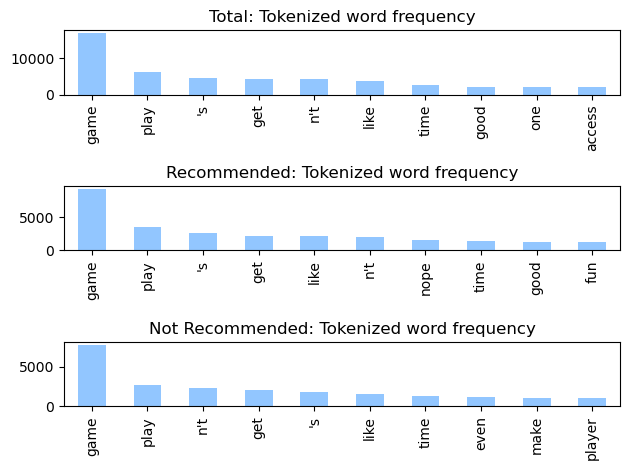

In [24]:
plt.subplot(3, 1, 1)
steam["advanced_tokenize"].explode().value_counts().head(10).plot(kind='bar', title='Total: Tokenized word frequency')
plt.subplot(3, 1, 2)
steam[steam["user_suggestion"]==1]["advanced_tokenize"].explode().value_counts().head(10).plot(kind='bar', title='Recommended: Tokenized word frequency')
plt.subplot(3, 1, 3)
ax = steam[steam["user_suggestion"]==0]["advanced_tokenize"].explode().value_counts().head(10).plot(kind='bar', title='Not Recommended: Tokenized word frequency')
plt.tight_layout()
plt.show()

## Create X and y set

In [25]:
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(steam["advanced_tokenize"].values)
y = steam["user_suggestion"]
print(X.shape)

(5248, 31033)


## Split Data and Train

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

## Evaluate Model

Accuracy: 0.8216463414634146


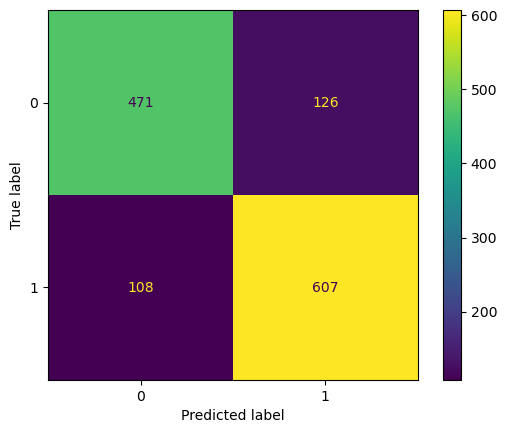

In [27]:
y_pred = model.predict(X_test)
#display(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## Try it out yourself with your own reviews!
(Make sure you tokenize the words the same way in this function as you did when you trained the model)

In [36]:
def try_advanced_model(game_review):
    stop_words = set(stopwords.words('english'))
    tokens = list(filter(lambda token: token not in string.punctuation, [PorterStemmer().stem(word) for word in nltk.word_tokenize(game_review.translate(string.punctuation)) if word.lower() not in stop_words]))
    mat = [[int(mlb.classes_[i] in tokens) for i in range(len(mlb.classes_))]]
    if model.predict(mat) == 1:
        return f"Model predicts: Recommend\nTokens: {tokens}"
    else:
        return f"Model predicts: Does Not Recommend\nTokens: {tokens}"

In [40]:
comment = "I saw a dog that looked more realistic than my actual dog 10/10"
print(try_advanced_model(comment))

Model predicts: Recommend
Tokens: ['saw', 'dog', 'look', 'realist', 'actual', 'dog', '10/10']
